## 상수 설정

In [1]:
FILE_NAME = "sample_data_60.csv"
FILE_PATH = f"data/{FILE_NAME}"
GROUP_COL = "month"
TARGET_COL = "text"
PROCESSED_COL = "ProcessedData"
HANSPELL_MAX_LENGTH = 500
KONLPY_MAX_LENGTH = 3000

## 패키지 설치 및 불러오기

### 전처리 과정에서 필요한 패키지 설치 및 불러오기

In [2]:
import sys
sys.executable

'/usr/bin/python3'

In [3]:
# !pip install py-hanspell

!git clone https://github.com/ssut/py-hanspell.git
!cd /usr/local/lib/python3.8/dist-packages/ && mkdir hanspell
!cd py-hanspell && cp -r hanspell/ /usr/local/lib/python3.8/dist-packages/

fatal: destination path 'py-hanspell' already exists and is not an empty directory.
mkdir: cannot create directory ‘hanspell’: File exists


In [4]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import site
import os
import pandas as pd
import re
from tqdm import tqdm
from hanspell import spell_checker
from konlpy.tag import Hannanum

### 토픽 모델링 과정에서 필요한 패키지 설치 및 불러오기

In [6]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from gensim import corpora
import numpy as np
import nltk
nltk.download('punkt')
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.gensim_models 
import gensim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


## 데이터 및 사전 불러오기 및 사전 중복 검사

In [8]:
def duplicate_check(df, dictionary_name):

    src = list(df)[0]
    dest = list(df)[1]
    
    dup = df.duplicated([src])
    df_dup = pd.concat([df, dup], axis=1)
    df_dup.rename(columns={0: 'Dup'}, inplace=True)
    df_dup['Dup'].value_counts()

    if df_dup['Dup'].values.sum() > 0:
        print(f"{dictionary_name}에서 중복 key 값이 발견되었습니다!")
        for i in range(len(df_dup)):
            if df_dup['Dup'][i]:
                # print(f"중복되는 key 값 : {df_dup['#en'][i]} (index at {i})")
                print(f"중복되는 key 값 : {df_dup[src][i]} (index at {i})")

    else:
        print(f"{dictionary_name}에서 중복되는 값이 없습니다.")
    
    print("사전에서 읽어들인 용어의 개수 :", len(df), "\n")

In [9]:
user_dic_df = pd.read_csv("data/dictionary/user_dic_syn.csv", encoding="utf-8", low_memory=False)
stopwords_df = pd.read_csv("data/dictionary/stopwords.csv", encoding="utf-8", low_memory=False)
fix_df = pd.read_csv("data/dictionary/spell_fix.csv", encoding="utf-8", low_memory=False)

duplicate_check(user_dic_df, "user_dic_df")
duplicate_check(stopwords_df, "stopwords_df")
duplicate_check(fix_df, "fix_df")

user_dic_df에서 중복되는 값이 없습니다.
사전에서 읽어들인 용어의 개수 : 0 

stopwords_df에서 중복 key 값이 발견되었습니다!
중복되는 key 값 : 저는 (index at 797)
중복되는 key 값 : 줄일 (index at 870)
중복되는 key 값 : 기타 (index at 1098)
중복되는 key 값 : 아우 (index at 1246)
사전에서 읽어들인 용어의 개수 : 1437 

fix_df에서 중복되는 값이 없습니다.
사전에서 읽어들인 용어의 개수 : 401 



In [10]:
syn_df = pd.read_csv("data/dictionary/synonym.csv", encoding="utf-8", low_memory=False)

for idx in range(len(syn_df['삭제여부'])):
    if syn_df['삭제여부'][idx]==True:
        syn_df['synonym'][idx] = "" 

# synonym 행 중 값이 없는 행은 삭제
syn_df = syn_df[syn_df['synonym'].notna()] 
syn_df = syn_df[['word', 'synonym']] 

# index 재구성
len_syn = len(syn_df['synonym'])
syn_index = [i for i in range(len_syn)]
syn_df = syn_df.set_index(pd.Index(syn_index))  

duplicate_check(syn_df, "syn_df")

<ipython-input-10-2ebdc292b273>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_df['synonym'][idx] = ""


syn_df에서 중복 key 값이 발견되었습니다!
중복되는 key 값 : 해주세요 (index at 1741)
중복되는 key 값 : 안늘어나 (index at 1770)
중복되는 key 값 : 관계요 (index at 3269)
사전에서 읽어들인 용어의 개수 : 4512 



In [11]:
final_fix_df = pd.read_csv("data/dictionary/final_fix.csv", encoding="utf-8", low_memory=False)

final_fix_df = final_fix_df[['problem', 'fix']] 
final_fix_df = final_fix_df[final_fix_df['problem'].notna()] 
final_fix_df = final_fix_df.fillna(' ')

duplicate_check(final_fix_df, "final_fix_df")

final_fix_df에서 중복 key 값이 발견되었습니다!
중복되는 key 값 : 안나오 (index at 20)
중복되는 key 값 : 안준단 (index at 21)
중복되는 key 값 : 불편해 (index at 22)
중복되는 key 값 : 두시간 (index at 23)
중복되는 key 값 : 필요해 (index at 24)
중복되는 key 값 : 안먹어 (index at 25)
중복되는 key 값 : 안나와 (index at 26)
사전에서 읽어들인 용어의 개수 : 49 



In [12]:
try:
  KONLPY_DIC_PATH = '/konlpy/java/data/kE/dic_user.txt'

  correct_path_cnt = 0 # KONLPY_DIC_PATH를 가지고 있는 경로가 1개 뿐이어야 함

  for sitepackages_path in site.getsitepackages():
    if os.path.isfile(sitepackages_path + KONLPY_DIC_PATH) == True:
      correct_path_cnt += 1
      DATA_PATH = sitepackages_path + KONLPY_DIC_PATH

  if correct_path_cnt > 1: # KONLPY_DIC_PATH를 가지고 있는 경로가 중복될 경우
    raise Exception("konlpy 라이브러리를 포함하는 site-packages의 경로가 여러 개 있습니다.\n!pip show konlpy 명령어 실행 후, \"Location:\"에 있는 경로를 직접 입력해주세요. ")

except:
  DATA_PATH = input("\n`!pip show konlpy` 명령어를 실행하여 확인한 \"Location:\"에 있는 경로를 직접 입력해주세요. : ")

In [13]:
dic_user_df = pd.read_table('data/dictionary/dic_user.txt')
dic_user_df.to_csv(DATA_PATH, index=False, header=False, sep='\t')
duplicate_check(dic_user_df, "dic_user.txt")

hannanum = Hannanum()

dic_user.txt에서 중복 key 값이 발견되었습니다!
중복되는 key 값 : 안운 (index at 1164)
중복되는 key 값 : 점프 (index at 1530)
중복되는 key 값 : 물 (index at 2369)
중복되는 key 값 : 반품 (index at 2377)
중복되는 key 값 : 반점 (index at 2378)
중복되는 key 값 : 반입 (index at 2379)
중복되는 key 값 : 반응 (index at 2380)
중복되는 key 값 : 반사 (index at 2381)
중복되는 key 값 : 반복 (index at 2382)
중복되는 key 값 : 반반 (index at 2383)
중복되는 key 값 : 반모 (index at 2384)
중복되는 key 값 : 반란 (index at 2385)
중복되는 key 값 : 반대 (index at 2386)
중복되는 key 값 : 바보 (index at 2387)
중복되는 key 값 : 바닥 (index at 2388)
중복되는 key 값 : 바늘 (index at 2389)
중복되는 key 값 : 밀봉 (index at 2390)
중복되는 key 값 : 민망 (index at 2391)
중복되는 key 값 : 믹스 (index at 2392)
중복되는 key 값 : 미용 (index at 2393)
중복되는 key 값 : 미열 (index at 2394)
중복되는 key 값 : 미안 (index at 2395)
중복되는 key 값 : 미숙 (index at 2396)
중복되는 key 값 : 미련 (index at 2397)
중복되는 key 값 : 미달 (index at 2398)
중복되는 key 값 : 물총 (index at 2399)
중복되는 key 값 : 물집 (index at 2400)
중복되는 key 값 : 물양 (index at 2401)
중복되는 key 값 : 물건 (index at 2402)
중복되는 key 값 : 문제 (index at 2403)
중복되는 ke

In [14]:
data = pd.read_csv(FILE_PATH, low_memory=False)
print(f"{FILE_PATH}에서 {len(data)}개의 data를 불러왔습니다.")

data/sample_data_60.csv에서 60개의 data를 불러왔습니다.


In [15]:
data

,title,month,text
0,안녕하세요 잘 안먹는아이 분유추천좀요,5개월,5개월에 막 들어섰어요50일째때까지만 해도 엄청 잘먹었는데이후 70일 백일.. 먹는...
1,수유양좀 알려주세요~~,1개월,57일아가이고 5.4kg 혼합이예요 최대한 낮에 직수하려하는데 새벽에는 많이 빠는데...
2,"살 ""안""찌는 분유 좀 추천 해 주세요.",2개월,제목 그대로 살찌는 분유 말구요 살 '안'찌는 분유 좀 추천 해 주세요. 오늘 예방...
3,35일차 모유시 한쪽만 먹기ㆍ글고 짜증내요,1개월,현제 35일차고둘다를 빨면 양 괜챠는것도 같은데.각 70미리 정도?요즘엔 한쪽 중심...
4,젖꼭지 사이즈,2개월,71일 남아에요 35일쯤부터 s 사이즈 사용 했구요 요즘 맘마먹으면서 용쓰기도 많이...
5,힙 분유 게어냄이 심해요ㅜ,3개월,"조리원에서부터 임페리얼먹이다 변비, 녹변, 코로 토함-> 노발락 스테이지1 , it..."
6,소화시키는 시간이 긴 아가ㅠㅠ,2개월,78일된 아기 분유때문에 너무 힘드네요..소화를 못 시켜서 분유바꾼게 지금 4번째에...
7,혼합인데 모유수유가 힘들어요ㅜ,1개월,45일차에 교정 7일 아기인데조리원서 혼합하다 집에서 완모로 하던중황달이 계속 안잡...
8,단유 해야하는데 맘이 안좋네요 ㅠㅠ,1개월,조리원에 있을때까지만 해도 유축도 제때하고 모유량도 조금씩 늘었었는데 조리원 퇴실하...
9,아기가 한쪽을 못물어요.,1개월,생후 35일 아기입니다.보호기 사용하다 28일째부터 떼기 시작했어요.오른쪽은 유두가...


### 데이터의 결측값 여부 확인

In [16]:
print(f"총 데이터(row)의 수 : {len(data)}")

print(f"\n===== {TARGET_COL} column의 결측값 여부 확인 =====")
print('결측값 여부 :', data[TARGET_COL].isnull().values.any())
print(f"원본 데이터의 유니크한 값 : {data[TARGET_COL].nunique()}")

print(f"\n===== {GROUP_COL} column의 결측값 여부 확인 =====")
print('결측값 여부 :', data[GROUP_COL].isnull().values.any())
print(f"원본 데이터의 유니크한 값 : {data[GROUP_COL].nunique()}")

총 데이터(row)의 수 : 60

===== text column의 결측값 여부 확인 =====
결측값 여부 : False
원본 데이터의 유니크한 값 : 60

===== month column의 결측값 여부 확인 =====
결측값 여부 : False
원본 데이터의 유니크한 값 : 11


## 토픽 모델링을 위한 전처리 작업

In [17]:
data[PROCESSED_COL] = [False for _ in range(len(data[TARGET_COL]))]

### 개행 문자 (`CRLF`) 제거

In [18]:
def remove_CRLF(input_str):
    input_str = input_str.replace("\n", " ")
    input_str = input_str.replace("\\n", " ")
    input_str = input_str.replace("\r", " ")
    input_str = input_str.replace("\\r", " ")

    return input_str

In [19]:
for i in range(len(data[TARGET_COL])):
    data[PROCESSED_COL][i] = remove_CRLF(data[TARGET_COL][i])

<ipython-input-19-0c0c92858e6a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[PROCESSED_COL][i] = remove_CRLF(data[TARGET_COL][i])
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### 이모티콘 문자들, 사이트 URL 주소, 의미없는 문자 지우기

In [20]:
def cleansing(input_str):
    output_str = re.sub(pattern='<[U]\+[A-Z0-9]*>', repl=' ', string=input_str)
    output_str = re.sub(pattern='http[s]?://(?:[a-zA-Z]|[0-9]|[_$\-@\.&+:/?=]|[!*\(\),]|(?:%[0-9a-fA-F_][0-9a-fA-F_]))+', repl=' ', string=output_str)
    output_str = re.sub(pattern='^[0-9]+$', repl=' ', string=output_str)

    return output_str

<>:2: DeprecationWarning: invalid escape sequence \+
<>:3: DeprecationWarning: invalid escape sequence \-
<>:2: DeprecationWarning: invalid escape sequence \+
<>:3: DeprecationWarning: invalid escape sequence \-
<ipython-input-20-979b4ebbfe80>:2: DeprecationWarning: invalid escape sequence \+
  output_str = re.sub(pattern='<[U]\+[A-Z0-9]*>', repl=' ', string=input_str)
<ipython-input-20-979b4ebbfe80>:3: DeprecationWarning: invalid escape sequence \-
  output_str = re.sub(pattern='http[s]?://(?:[a-zA-Z]|[0-9]|[_$\-@\.&+:/?=]|[!*\(\),]|(?:%[0-9a-fA-F_][0-9a-fA-F_]))+', repl=' ', string=output_str)


In [21]:
for i in range(len(data[TARGET_COL])):    
    data[PROCESSED_COL][i] = cleansing(data[PROCESSED_COL][i])

### 맞춤법 및 띄어쓰기 교정

In [22]:
def spell_check(input_str):
    output_str = input_str.replace("&", " ")

    try:
        tmp = spell_checker.check(output_str).checked # 500자가 넘는 경우 빈 문자열로 반환됨
        if tmp!="": 
            output_str = tmp
    except:
        print("hanspell : spell_checker error\n")
    
    return output_str

In [23]:
print("Spell checking start")

for i in tqdm(range(len(data[TARGET_COL]))):
    data[PROCESSED_COL][i] = spell_check(data[PROCESSED_COL][i])

Spell checking start


100%|██████████| 60/60 [00:23<00:00,  2.54it/s]


#### 교정 오류 수정

In [24]:
def spell_fix(spell_checked_str):
    for i in range(len(fix_df["fix"])):
        spell_checked_str = spell_checked_str.replace(fix_df["problem"][i], fix_df["fix"][i])

    return spell_checked_str

In [25]:
for i in tqdm(range(len(data[TARGET_COL]))):
    data[PROCESSED_COL][i] = spell_fix(data[PROCESSED_COL][i])

100%|██████████| 60/60 [00:01<00:00, 58.64it/s]


### 데이터의 앞뒤에 공백 추가

In [26]:
def add_space(input_str):
    return " "+input_str+" "

In [27]:
for i in range(len(data[TARGET_COL])):
    data[PROCESSED_COL][i] = add_space(data[PROCESSED_COL][i])

### 토큰화 전 불용어(stopwords) 제거

In [28]:
def remove_stopwords(input_str):
    input_str = re.sub(pattern='([0-9ㄱ-ㅎㅏ-ㅣ]+)', repl='', string=input_str)
    for i in range(len(stopwords_df["nursing"].dropna())):
        input_str = input_str.replace(" "+stopwords_df["nursing"][i]+" ", " ")
    for i in range(len(stopwords_df["korean"].dropna())):
        input_str = input_str.replace(" "+stopwords_df["korean"][i]+" ", " ")
    for i in range(len(stopwords_df["internet"].dropna())):
        input_str = input_str.replace(stopwords_df["internet"][i], " ")
    output_str = re.sub("\s+", " ", input_str)

    return output_str

<>:9: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \s
<ipython-input-28-aff2050e5d55>:9: DeprecationWarning: invalid escape sequence \s
  output_str = re.sub("\s+", " ", input_str)


In [29]:
for i in tqdm(range(len(data[TARGET_COL]))):
    data[PROCESSED_COL][i] = remove_stopwords(data[PROCESSED_COL][i])

100%|██████████| 60/60 [00:01<00:00, 30.15it/s]


### 토큰화

In [30]:
def tokenization(input_str):
    if input_str.strip() == "": # 문장이 비어있는 경우
        return " "

    elif len(input_str)>KONLPY_MAX_LENGTH: # 문장이 3000자가 넘어갈 때
        # 3000 문자당 자르기
        doc = input_str
        split_list = [doc[i:i+KONLPY_MAX_LENGTH] for i in range(0, len(doc), KONLPY_MAX_LENGTH)]
        
        tmp_list = []
        for phrase in split_list:
            tmp_list = tmp_list + hannanum.nouns(phrase)
            
        temp_list = []
        for word in tmp_list:
            temp_list.append(re.sub(r'[0-9]+', '', word))
        
        return " "+" ".join(temp_list)+" "
        
    else: # 문장이 3000자 미만일 때
        tmp_list = hannanum.nouns(input_str)
        temp_list = []
        for word in tmp_list:
            temp_list.append(re.sub(r'[0-9]+', '', word))

        return " "+" ".join(temp_list)+" "

In [31]:
for i in tqdm(range(len(data[TARGET_COL]))):
    data[PROCESSED_COL][i] = tokenization(data[PROCESSED_COL][i])

100%|██████████| 60/60 [00:07<00:00,  7.92it/s]


### 토큰화 후 불용어(stopwords) 제거

In [32]:
for i in tqdm(range(len(data[TARGET_COL]))):
    data[PROCESSED_COL][i] = remove_stopwords(data[PROCESSED_COL][i])

100%|██████████| 60/60 [00:00<00:00, 68.91it/s]


### 동의어 대체

In [33]:
def replace_synonyms(input_str, syn_df):
    TRG_COLUMN = syn_df.columns[0]
    SYN_COLUMN = syn_df.columns[1]

    for i in range(len(syn_df)):
        input_str = input_str.replace(" "+syn_df[TRG_COLUMN][i]+" ", " "+syn_df[SYN_COLUMN][i]+" ")

    return input_str

In [34]:
for i in tqdm(range(len(data[TARGET_COL]))):
    data[PROCESSED_COL][i] = replace_synonyms(data[PROCESSED_COL][i], syn_df)

100%|██████████| 60/60 [00:03<00:00, 16.65it/s]


### 한 글자 단어 제거

In [35]:
def remove_single_word_from_string(input_str):
    tokened_str_list = input_str.split(' ')
    copy_list = tokened_str_list.copy()
    
    for tk in tokened_str_list:
        if len(tk)<=1:
            copy_list.remove(tk)
    
    return " ".join(copy_list)

In [36]:
for i in range(len(data[TARGET_COL])):
    data[PROCESSED_COL][i] = remove_single_word_from_string(data[PROCESSED_COL][i])

### 최종 오류 수정

In [37]:
for i in tqdm(range(len(data[TARGET_COL]))):
    data[PROCESSED_COL][i] = replace_synonyms(data[PROCESSED_COL][i], final_fix_df)

100%|██████████| 60/60 [00:00<00:00, 1279.65it/s]


# 토픽 모델링

## 최적의 토픽 수 계산

In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = pyLDAvis.gensim_models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

def find_optimal_number_of_topics(dictionary, corpus, processed_data, limit=30):  
    start = 1; 
    step = 1; 
    
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step) 
    
    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence_values"), loc='best') 
        
    dic = { coherence_values:x for x, coherence_values in zip(x, coherence_values) }

    plt.text(dic[max(coherence_values)],min(coherence_values),
             str(dic[max(coherence_values)]) + ' at MAX',
             color='r',
             horizontalalignment='center',
             verticalalignment='bottom')
    
    plt.show()
    
    return dic[max(coherence_values)]

In [39]:
# 상위 1,000개의 단어를 보존 
vectorizer = TfidfVectorizer(stop_words='english', max_features= 1000)
X = vectorizer.fit_transform(data[PROCESSED_COL])

# TF-IDF 행렬의 크기 확인
print('TF-IDF 행렬의 크기 :',X.shape)

data["tokenized_text"] = data.apply(lambda row: nltk.word_tokenize(row[PROCESSED_COL]), axis=1)
tokenized_doc = data["tokenized_text"].apply(lambda x: [word for word in x if len(word) > 1])
dictionary = corpora.Dictionary(tokenized_doc)
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]
processed_data = list(np.array(tokenized_doc.tolist()))

TF-IDF 행렬의 크기 : (60, 438)


<ipython-input-39-1363809b0888>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  processed_data = list(np.array(tokenized_doc.tolist()))


/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

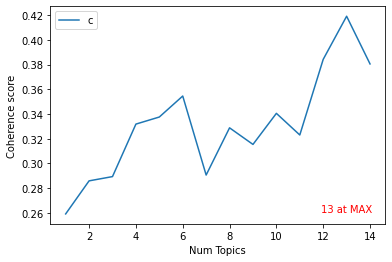

In [47]:
limit = 15
NUM_TOPICS = find_optimal_number_of_topics(dictionary, corpus, processed_data, limit)

## LDA 모델 생성

In [48]:
lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, learning_method='online', random_state=42, max_iter=1)

In [49]:
lda_top = lda_model.fit_transform(X)

In [50]:
# 단어 집합. 1,000개의 단어가 저장됨.
terms = vectorizer.get_feature_names()

def get_topics(components, feature_names, n=10):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [51]:
get_topics(lda_model.components_,terms)

Topic 1: [('시간', 1.23), ('빈도', 1.2), ('모유거부', 1.18), ('수유텀', 1.14), ('개월', 1.1), ('목표이긴', 1.09), ('초유', 1.09), ('아기', 1.08), ('수유량', 1.07), ('중심', 1.06)]
Topic 2: [('단유방법', 1.14), ('이야기', 1.11), ('먹이긴', 1.08), ('새벽', 1.08), ('위치', 1.07), ('단유', 1.06), ('키로인데몸무', 1.06), ('한스푼', 1.05), ('나오니깐', 1.05), ('성분', 1.04)]
Topic 3: [('잤어요너무', 1.07), ('끊으라하는데', 1.05), ('지인', 1.03), ('목표이긴', 1.01), ('마찬가지', 1.01), ('초유', 1.01), ('중요', 1.01), ('수술', 1.01), ('공유', 1.0), ('먹는데달달한', 1.0)]
Topic 4: [('잘못', 1.19), ('시간', 1.16), ('뭉치다', 1.1), ('딥슬립', 1.09), ('보충', 1.07), ('먹이다', 1.04), ('소화', 1.04), ('다른곳', 1.03), ('정신건강', 1.03), ('욕심', 1.02)]
Topic 5: [('젖먹', 1.12), ('안쓰럽다', 1.05), ('잘안물어서새벽', 1.04), ('젖병', 1.03), ('외출', 1.03), ('구니해요', 1.02), ('분유거부', 1.02), ('뱉어버리고짜증내', 1.02), ('받으러가', 1.01), ('많아서요다들', 1.01)]
Topic 6: [('단계', 1.1), ('분유명', 1.08), ('생활', 1.07), ('유두보호기', 1.05), ('불편해요유두', 1.03), ('힙콤비', 1.01), ('직수', 1.01), ('국내', 1.01), ('너무심해서압타밀', 1.01), ('지독', 1.0)]
Topic 7: [('뽑아냈는데그다음날엔', 1.1), 

In [52]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

## LDA 모델 시각화

In [53]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [54]:
pyLDAvis.save_html(vis, f"results/lda_{NUM_TOPICS}topics.html")

## LDA 값 저장

### beta 값 구하기

In [55]:
num_words=50
beta_list = ldamodel.print_topics(num_words)

# print(beta_list)
beta_df = pd.DataFrame(index=range(0,(len(beta_list)*num_words)), columns=['topic', 'term', 'beta'])

# 'topic' 열에 값 집어넣기
for i in range(len(beta_df)):
    beta_df['topic'][i]=int(i/num_words)%num_words

idx_cnt=0
for i in range(len(beta_list)):
#     print(beta_list[i][1].split(" + "))
#     print(len(beta_list))
    for j in range(num_words):
        try:
            beta_df['term'][idx_cnt]=beta_list[i][1].split(" + ")[j].split("*")[1]
            beta_df['beta'][idx_cnt]=beta_list[i][1].split(" + ")[j].split("*")[0]
        except: # topic에 단어가 num_words만큼 있지 않은 경우
            pass
        
        idx_cnt+=1
beta_df.to_csv(f"results/lda_beta_{NUM_TOPICS}topics.csv", mode='w')

### gamma 값 구하기

In [56]:
# 참고 :
# http://bigdata.emforce.co.kr/wp-content/uploads/%EC%97%A0%ED%8F%AC%EC%8A%A4-%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%9E%A9_%ED%86%A0%ED%94%BD%EB%AA%A8%EB%8D%B8%EB%A7%81LDA%EB%B0%A9%EB%B2%95%EB%A1%A0-%EC%A0%95%EB%A6%AC.pdf

def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()
    
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        
        for j, (topic_num, prop_topic) in enumerate(doc):
            if j==0:
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_list]), ignore_index=True)
            else:
                break
    return (topic_table)


topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index()
topictable.columns = ['문서번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중(gamma)', '각 토픽의 비중']
topictable.to_csv(f"results/lda_gamma_{NUM_TOPICS}topics.csv", mode='w')